In [66]:
import numpy as np
import tensorflow.keras as keras

from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from sklearn.decomposition import PCA

## Prepare the data

### Create the dataset

In [2]:
# Define docs
docs = [
    'Amazing!',
    'Well done!',
    'Great job!',
    'Good job',
    'Nicely done!',
    'Amazing job!',
    'Not bad!',
    'Very poor.',
    'Not well',
    'Not very well written',
    'Purely bad',
    'It\'s not good.',
    'Very badly done',
    'Very bad'
]
    
# Define labels
labels = np.array([1] * 7 + [0] * 7)

In [3]:
len(docs), len(labels)

(14, 14)

### Tokenize

In [4]:
# Tokenize the docs
tokenizer = keras.preprocessing.text.Tokenizer(50, oov_token = '<UNK>')
tokenizer.fit_on_texts(docs)

In [5]:
seqs = tokenizer.texts_to_sequences(docs)

In [6]:
# Sanity check
word_dict = {k: v for v, k in tokenizer.word_index.items()}

for doc in seqs[:4]:
    print(' '.join([word_dict[word] for word in doc]))

amazing
well done
great job
good job


### Pad

In [7]:
# Pad sequences
max_len = max([len(x) for x in seqs]) + 2

padded_seqs = pad_sequences(seqs, 
                            maxlen  = max_len, 
                            padding = 'post')

In [8]:
# Sanity check
padded_seqs

array([[ 8,  0,  0,  0,  0,  0],
       [ 4,  5,  0,  0,  0,  0],
       [10,  6,  0,  0,  0,  0],
       [ 9,  6,  0,  0,  0,  0],
       [11,  5,  0,  0,  0,  0],
       [ 8,  6,  0,  0,  0,  0],
       [ 2,  7,  0,  0,  0,  0],
       [ 3, 12,  0,  0,  0,  0],
       [ 2,  4,  0,  0,  0,  0],
       [ 2,  3,  4, 13,  0,  0],
       [14,  7,  0,  0,  0,  0],
       [15,  2,  9,  0,  0,  0],
       [ 3, 16,  5,  0,  0,  0],
       [ 3,  7,  0,  0,  0,  0]])

## Define the model

In [9]:
vocab_size = 50

In [59]:
model = keras.Sequential()

model.add(keras.layers.Embedding(vocab_size, 32, input_length = max_len))
model.add(keras.layers.Flatten())              # We need to flatten the array before the dense layer
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(.2))
model.add(keras.layers.Dense(32))
model.add(keras.layers.Dropout(.2))
model.add(keras.layers.Dense(1, activation = 'sigmoid'))

In [60]:
# Compile the model
model.compile(optimizer = 'adam', 
              loss      = 'binary_crossentropy', 
              metrics   = ['accuracy'])

In [61]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 6, 32)             1600      
_________________________________________________________________
flatten_7 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 32)                6176      
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_15 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                

In [62]:
# Fit the model
model.fit(padded_seqs, labels, epochs = 150, verbose = 0)

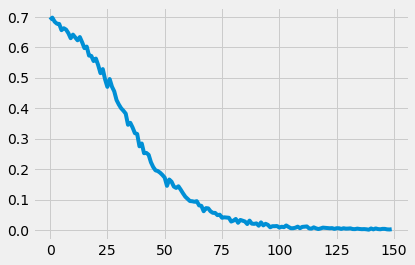

In [63]:
# plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['loss'])

## Predict

In [64]:
new_seq = tokenizer.texts_to_sequences(['Amazing! Incredibly great job!', 
                                        'Very poor, sorry!', 
                                        'Well done, good work!'])

new_seq = pad_sequences(new_seq, 
                            maxlen  = max_len, 
                            padding = 'post')

In [65]:
model.predict(new_seq)

array([[9.5814735e-01],
       [2.0411571e-06],
       [8.9118057e-01]], dtype=float32)

## Visualize the embeddings

In [75]:
# Get weights
embeddings = model.layers[0].get_weights()[0]

In [102]:
# Refer embeddings to words
words_embeddings = {w: embeddings[idx] for w, idx in tokenizer.word_index.items()}

emb_values = list(words_embeddings.values())
emb_texts  = list(words_embeddings.keys()) 

In [103]:
# PCA
pca = PCA(n_components = 2)
pca.fit(emb_values)
emb_2d = pca.transform(emb_values)

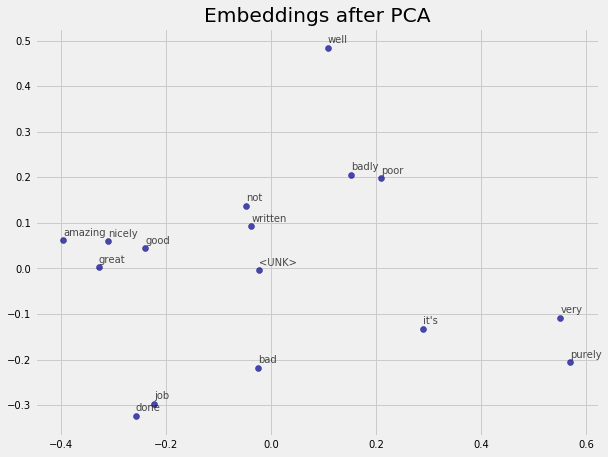

In [127]:
plt.figure(figsize = (9, 7))
for i, text in enumerate(emb_texts):
    x, y = emb_2d[i, 0], emb_2d[i, 1]
    plt.scatter(x, y, alpha = .7, color = 'darkblue')
    plt.text(x, y + .01, text, alpha = .7, fontsize = 10)
plt.title('Embeddings after PCA')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)
plt.show()